# Deep Learning with structured & time series data
---

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

# Import Libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
PATH='../data/rossman/'

# Load datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [6]:
! mkdir ../data/rossman/
! curl -o ../data/rossman/rossman.tgz http://files.fast.ai/part2/lesson14/rossmann.tgz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7549k  100 7549k    0     0  3686k      0  0:00:02  0:00:02 --:--:-- 3686k


In [15]:
! tar -xvzf ../data/rossman/rossman.tgz -C ../data/rossman/

googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv


In [13]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

**Results in Huge File Size**

#concat_csvs('googletrend')
#concat_csvs('weather')

# EDA


**Feature Space:**
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [4]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [5]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [6]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [7]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [8]:
tables[0].describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
# for t in tables: display(DataFrameSummary(t).summary())
for t in tables: display(t.describe())

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


,Store
count,1115.00000
mean,558.00000
std,322.01708
min,1.00000
25%,279.50000
50%,558.00000
75%,836.50000
max,1115.00000


,StateName,State
count,16,16
unique,16,16
top,Berlin,ST
freq,1,1


,trend
count,2072.000000
mean,63.814189
std,12.650246
min,0.000000
25%,55.000000
50%,64.000000
75%,72.000000
max,100.000000


,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,...,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,WindDirDegrees
count,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,...,15840.000000,15459.000000,15459.000000,15459.000000,15840.000000,15840.000000,3604.000000,15840.000000,14667.000000,15840.000000
mean,14.644129,10.388952,6.198990,8.587816,6.205808,3.626136,93.659596,74.282891,50.158586,1018.532197,...,1012.307955,24.057572,12.239796,7.025163,22.766604,11.972222,48.864317,0.831718,5.551306,175.896717
std,8.646012,7.379260,6.526391,6.244780,6.086768,6.128390,7.678530,13.486552,19.960216,7.788720,...,8.600585,8.976799,5.067944,4.980602,8.988618,5.872844,13.026954,2.513506,1.687710,101.588872
min,-11.000000,-13.000000,-15.000000,-14.000000,-15.000000,-73.000000,44.000000,30.000000,4.000000,976.000000,...,970.000000,0.000000,0.000000,0.000000,3.000000,2.000000,21.000000,0.000000,0.000000,-1.000000
25%,8.000000,4.000000,1.000000,4.000000,2.000000,-1.000000,90.750000,65.000000,34.000000,1014.000000,...,1007.000000,14.000000,10.000000,3.000000,16.000000,8.000000,39.000000,0.000000,5.000000,80.000000
50%,15.000000,11.000000,7.000000,9.000000,7.000000,4.000000,94.000000,76.000000,49.000000,1019.000000,...,1013.000000,31.000000,11.000000,7.000000,21.000000,11.000000,48.000000,0.000000,6.000000,202.000000
75%,21.000000,16.000000,11.000000,13.000000,11.000000,8.000000,100.000000,85.000000,66.000000,1024.000000,...,1018.000000,31.000000,14.000000,10.000000,27.000000,14.000000,55.000000,0.250000,7.000000,256.000000
max,39.000000,31.000000,24.000000,25.000000,20.000000,19.000000,100.000000,100.000000,100.000000,1043.000000,...,1038.000000,31.000000,31.000000,31.000000,101.000000,53.000000,111.000000,58.930000,8.000000,360.000000


,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


# Data Cleaning & Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [11]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [12]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [13]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

## 1. Join weather and state data

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [14]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [15]:
weather = join_df(weather, state_names, "file", "StateName")

In [16]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW


## 2. Extract Data and State from google trend data

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [17]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [20]:
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


In [19]:
googletrend['State'].unique()

array(['SN', None, 'BY', 'TH', 'NW', 'BE', 'RP', 'BW', 'HB,NI', 'SH', 'HE', 'ST', 'HH', 'SL'], dtype=object)

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

## 3. Add datapart features

In [22]:
?add_datepart()

Signature: add_datepart(df, fldname, drop=True, time=False)
Docstring:
add_datepart converts a column of df from a datetime64 to many columns containing
the information from the date. This applies changes inplace.

Parameters:
-----------
df: A pandas data frame. df gain several new columns.
fldname: A string that is the name of the date column you wish to expand.
    If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
drop: If true then the original date column will be removed.
time: If true time features: Hour, Minute, Second will be added.

Examples:
---------

>>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
>>> df

    A
0   2000-03-11
1   2000-03-12
2   2000-03-13

>>> add_datepart(df, 'A')
>>> df

    AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
0   2000  3      10    11   5      

In [23]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

## 4. Use Germany data from google trends

The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [24]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [25]:
trend_de.head()

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
148,Rossmann_DE,2012-12-02 - 2012-12-08,77,2012-12-02,None,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
149,Rossmann_DE,2012-12-09 - 2012-12-15,76,2012-12-09,None,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
150,Rossmann_DE,2012-12-16 - 2012-12-22,85,2012-12-16,None,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
151,Rossmann_DE,2012-12-23 - 2012-12-29,59,2012-12-23,None,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
152,Rossmann_DE,2012-12-30 - 2013-01-05,61,2012-12-30,None,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


## 5. Outer Join all data

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [26]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [27]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [28]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [29]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [30]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [31]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

## 6. Fill missing values

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [32]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [40]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [41]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107


## 7. Data cleaning for outliers and high cardinality categories

We'll replace some erroneous / outlying data.

In [42]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [43]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [44]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [45]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [46]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## 8. Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [47]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [48]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [49]:
df = train[columns]

In [51]:
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1


In [54]:
df = test[columns]

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [53]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')

In [56]:
df.tail(10)

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday
11149,2015-07-22,1115,0,False,0,103.0
10034,2015-07-23,1115,0,False,0,104.0
8919,2015-07-24,1115,0,False,0,105.0
7804,2015-07-25,1115,0,False,0,106.0
6689,2015-07-26,1115,0,False,0,107.0
5574,2015-07-27,1115,1,False,1,0.0
4459,2015-07-28,1115,1,False,1,0.0
3344,2015-07-29,1115,1,False,1,0.0
2229,2015-07-30,1115,1,False,1,0.0
1114,2015-07-31,1115,1,False,1,0.0


In [57]:
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [60]:
df.head(10)

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-07-31,1,1,False,1,0.0,0.0
1115,2015-07-30,1,1,False,1,0.0,0.0
2230,2015-07-29,1,1,False,1,0.0,0.0
3345,2015-07-28,1,1,False,1,0.0,0.0
4460,2015-07-27,1,1,False,1,0.0,0.0
5575,2015-07-26,1,0,False,0,107.0,-1.0
6690,2015-07-25,1,0,False,0,106.0,-2.0
7805,2015-07-24,1,0,False,0,105.0,-3.0
8920,2015-07-23,1,0,False,0,104.0,-4.0
10035,2015-07-22,1,0,False,0,103.0,-5.0


We'll do this for two more fields.

In [61]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [62]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

## 9. Set active index to Date

We're going to set the active index to Date.

In [63]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [64]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [65]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

## 10. Rolling quantiles

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [66]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [67]:
bwd.head()

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2013-01-01    1.0            1.0           1.0    0.0
      2013-01-02    2.0            2.0           1.0    0.0
      2013-01-03    3.0            3.0           1.0    0.0
      2013-01-04    4.0            4.0           1.0    0.0
      2013-01-05    5.0            5.0           1.0    0.0

In [69]:
fwd = df[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [70]:
fwd.head()

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2015-07-31    1.0            1.0           0.0    1.0
      2015-07-30    2.0            2.0           0.0    2.0
      2015-07-29    3.0            3.0           0.0    3.0
      2015-07-28    4.0            4.0           0.0    4.0
      2015-07-27    5.0            5.0           0.0    5.0

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [71]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [72]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [73]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [74]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [75]:
df.drop(columns,1,inplace=True)

In [76]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


# Saving all dataframes

It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [77]:
df.to_feather(f'{PATH}df')

In [78]:
df = pd.read_feather(f'{PATH}df')

In [79]:
df["Date"] = pd.to_datetime(df.Date)

In [80]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [81]:
joined = join_df(joined, df, ['Store', 'Date'])

In [82]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [83]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [84]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [85]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

# Create features

In [4]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [5]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


## 1. Categorical and Continuous features

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [6]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [7]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [13]:
joined.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date
0,1,5,2015,7,31,False,24,0,c,a,...,11,1.0,85,83,57,0,1,1,5263,2015-07-31
1,2,5,2015,7,31,False,24,25,a,a,...,11,4.0,80,83,67,0,1,1,6064,2015-07-31
2,3,5,2015,7,31,False,24,25,a,a,...,5,2.0,86,83,57,0,1,1,8314,2015-07-31
3,4,5,2015,7,31,False,24,0,c,c,...,16,6.0,74,83,67,0,1,1,13995,2015-07-31
4,5,5,2015,7,31,False,3,0,a,a,...,11,4.0,82,83,57,0,1,1,4822,2015-07-31


In [10]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [12]:
joined_test.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date,Id
0,1,4,2015,9,17,False,24,0,c,a,...,6.0,69,67,NaN,NaN,1,0,0,2015-09-17,1
1,3,4,2015,9,17,False,24,25,a,a,...,6.0,68,67,NaN,NaN,1,0,0,2015-09-17,2
2,7,4,2015,9,17,False,24,0,a,c,...,5.0,59,67,NaN,NaN,1,0,0,2015-09-17,3
3,8,4,2015,9,17,False,11,0,a,a,...,5.0,59,67,NaN,NaN,1,0,0,2015-09-17,4
4,9,4,2015,9,17,False,24,0,a,c,...,6.0,68,67,NaN,NaN,1,0,0,2015-09-17,5


In [14]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [16]:
apply_cats(joined_test, joined)

In [17]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

We're going to run on a sample.

In [18]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [84]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [19]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,2015,6,16,False,24,0,a,a,...,18.0,8.0,6.0,63.0,71.0,22.0,0.0,1.0,0.0,5934
2013-10-30,4,3,2013,10,30,False,24,0,c,c,...,29.0,16.0,2.0,74.0,66.0,27.0,-56.0,0.0,0.0,7800


In [20]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

**DataFrameMapper**  
The mapper takes a list of tuples. The first is a column name from the pandas DataFrame, or a list containing one or multiple columns (we will see an example with multiple columns later). The second is an object which will perform the transformation which will be applied to that column. The third is optional and is a dictionary containing the transformation options, if applicable.

In [23]:
nas, mapper

({}, DataFrameMapper(default=False, df_out=False,
         features=[(['CompetitionDistance'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Max_TemperatureC'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Mean_TemperatureC'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Min_TemperatureC'], StandardScaler(co...rue, with_std=True)), (['SchoolHoliday'], StandardScaler(copy=True, with_mean=True, with_std=True))],
         input_df=False, sparse=False))

In [28]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [29]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,3,6,16,1,25,1,1,1,...,-0.756430,-0.519502,-0.651394,0.413263,-0.194358,0.487305,-0.525077,1.109608,1.115768,-0.489079
2013-10-30,4,3,1,10,30,1,25,1,3,3,...,-0.095984,0.704530,0.700532,-1.400579,0.769911,-0.026011,-0.363976,-0.602128,-0.896244,-0.489079


# Generate Cross Validation Set

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [31]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [34]:
val_idx = np.flatnonzero((df.index<=datetime.datetime(2014,9,17)) 
                         & (df.index>=datetime.datetime(2014,8,1)))

In [37]:
len(val_idx), val_idx

(6763,
 array([    24,     31,     37,     47,     81,     87,    102,    104,    125,    136,    159,    189,
           190,    235,    265,    281,    317,    356,    357,    375, ..., 149583, 149612, 149653, 149674,
        149681, 149686, 149712, 149718, 149755, 149769, 149818, 149822, 149824, 149826, 149831, 149841,
        149867, 149932, 149950, 149976]))

# Build DL Model

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [38]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [39]:
?ColumnarModelData

Init signature: ColumnarModelData(path, trn_ds, val_ds, bs, test_ds=None, shuffle=True)
Docstring:      Encapsulates DataLoaders and Datasets for training, validation, test. Base class for fastai *Data classes.
File:           ~/fastai/fastai/column_data.py
Type:           type


In [40]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [42]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [43]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [44]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [45]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [47]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [48]:
m.lr_find()

 66%|██████▌   | 735/1120 [00:24<00:13, 29.48it/s, loss=0.528]

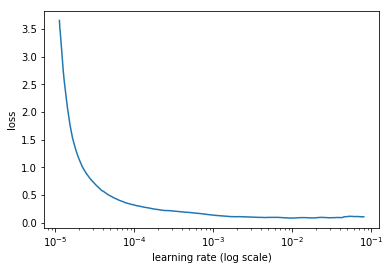

In [49]:
m.sched.plot()

In [55]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(sched.lrs)):
        derivative = (sched.losses[i] - sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)
    
    best_lr = sched.lrs[np.argmin(derivatives)]
    return best_lr

1.1453245540078342e-05

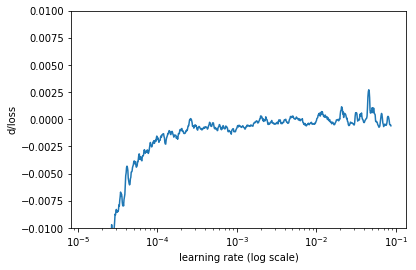

In [58]:
plot_loss_change(m.sched, sma=5)

# Train Model

In [65]:
def plot_loss(learner, n_skip=10, n_skip_end=5):
    '''
    plots training loss and validation loss as function of iterations. 
    '''
    fig, ax = plt.subplots()
    ax.plot(learner.sched.iterations,learner.sched.losses, label='Training Loss')
    ax.scatter(learner.sched.epochs, learner.sched.val_losses, c='red', label='Validation Loss')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.legend()
    fig.tight_layout()

In [61]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-5

## Basic training with best learning rate

In [62]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.22564    0.207774   0.494146  
    1      0.174574   0.159338   0.408175  
    2      0.132539   0.128121   0.352887  


[array([0.12812]), 0.35288698672898305]

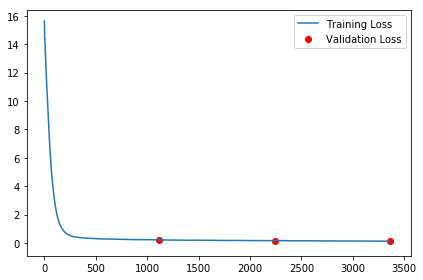

In [63]:
plot_loss(m)

## Training with Cyclical Learning Rates

In [64]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.11236    0.110243   0.32319   
    1      0.092061   0.09241    0.289975  
    2      0.075895   0.075704   0.264151  
    3      0.063811   0.065627   0.245389  
    4      0.055591   0.05934    0.233515  


[array([0.05934]), 0.23351548859470328]

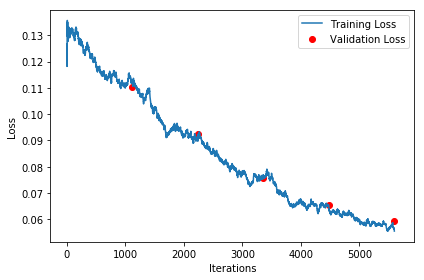

In [66]:
plot_loss(m)

In [67]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.050628   0.054042   0.221013  
    1      0.046891   0.049111   0.214218  
    2      0.044402   0.048162   0.212227  
    3      0.046518   0.048374   0.211444  
    4      0.042251   0.045963   0.207872  
    5      0.042314   0.044739   0.20218   
    6      0.03912    0.042773   0.200942  
    7      0.038534   0.042805   0.200258  


[array([0.04281]), 0.20025798087933966]

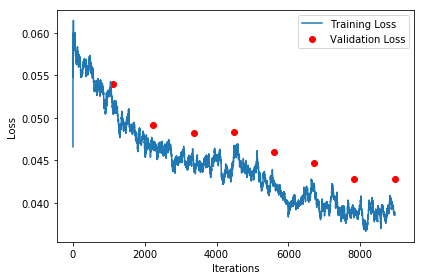

In [68]:
plot_loss(m)

**Note: It has started to overfit**

## Increase dropout to prevent overfitting

In [78]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.1, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [79]:
m.lr_find()

 67%|██████▋   | 755/1120 [00:24<00:11, 30.70it/s, loss=0.529]

1.1312834366320192e-05

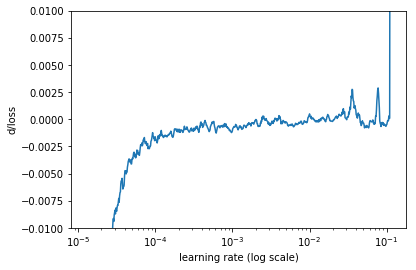

In [80]:
plot_loss_change(m.sched, sma=5)

In [81]:
lr = 1e-5

In [82]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.200756   0.191118   0.402714  
    1      0.162833   0.144027   0.368614  
    2      0.124412   0.117106   0.322872  


[array([0.11711]), 0.3228723273557029]

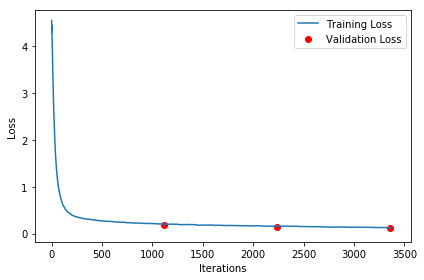

In [83]:
plot_loss(m, n_skip=100)

In [84]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.109347   0.104404   0.295875  
    1      0.088965   0.08669    0.270732  
    2      0.081331   0.07464    0.250341  
    3      0.070513   0.066548   0.235498  
    4      0.063223   0.061849   0.226067  


[array([0.06185]), 0.22606700654123235]

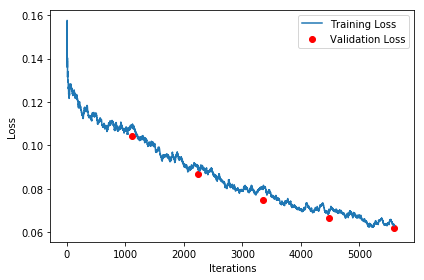

In [85]:
plot_loss(m)

In [86]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.058389   0.055743   0.214899  
    1      0.053396   0.051184   0.208146  
    2      0.050782   0.051843   0.207287  
    3      0.05127    0.051714   0.207223  
    4      0.048926   0.047302   0.200012  
    5      0.046886   0.04683    0.197957  
    6      0.043873   0.04741    0.197762  
    7      0.042653   0.046577   0.196895  


[array([0.04658]), 0.1968954227463822]

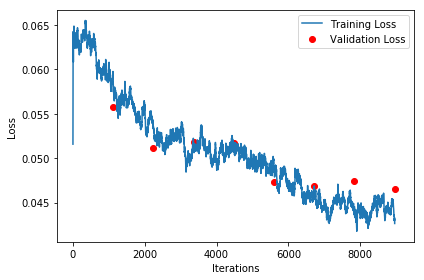

In [87]:
plot_loss(m)

**Note: Dropout prevented overfitting**

In [88]:
m.save('embd1')

In [109]:
m.load('embd1')

## More training

In [167]:
m2 = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), emb_drop=0.1, out_sz=1, szs=[1000,500], drops=[0.001, 0.01], y_range=y_range)

In [168]:
m2.load('embd1')

In [169]:
m2.lr_find()

 62%|██████▎   | 700/1120 [00:22<00:13, 30.87it/s, loss=0.233]

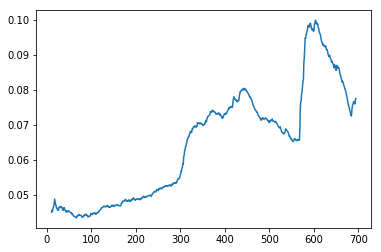

In [170]:
m2.sched.plot_loss()

1.0505786516024188e-05

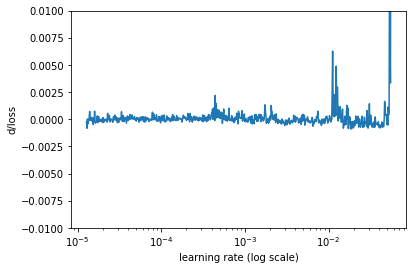

 62%|██████▎   | 700/1120 [00:40<00:24, 17.50it/s, loss=0.233]

In [171]:
plot_loss_change(m2.sched)

In [172]:
lr = 1e-5

In [173]:
m2.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.043603   0.04569    0.195507  
    1      0.041903   0.046906   0.195133  
    2      0.038741   0.044629   0.192493  
    3      0.040714   0.041081   0.187445  
    4      0.038863   0.043046   0.189485  
    5      0.038321   0.041578   0.186845  
    6      0.036722   0.041942   0.187271  


[array([0.04194]), 0.1872711537740998]

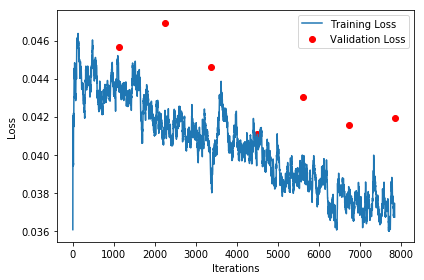

In [174]:
plot_loss(m2)

In [175]:
m2.save('embd2')

### Trying more dropout

In [179]:
m3 = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), emb_drop=0.1, out_sz=1, szs=[1000,500], drops=[0.001, 0.02], y_range=y_range)

In [180]:
m3.load('embd1')

In [181]:
m3.lr_find()

 62%|██████▏   | 692/1120 [00:35<00:21, 19.68it/s, loss=0.197]

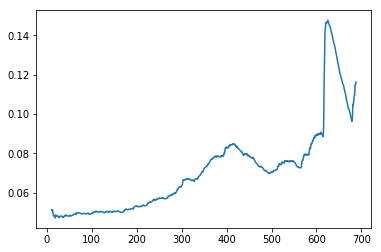

In [182]:
m3.sched.plot_loss()

1.1739317729588827e-05

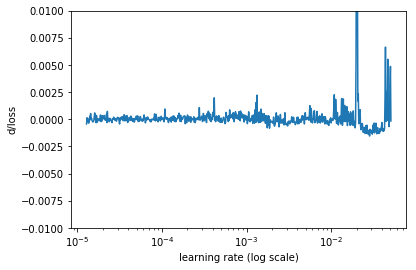

In [183]:
plot_loss_change(m3.sched)

In [184]:
lr = 1e-5

In [185]:
m3.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.046586   0.047554   0.19729   
    1      0.045623   0.042667   0.191367  
    2      0.044786   0.045489   0.193783  
    3      0.042473   0.044693   0.19116   
    4      0.04242    0.045142   0.19162   
    5      0.042062   0.043273   0.188675  
    6      0.039353   0.042112   0.187371  


[array([0.04211]), 0.1873711493275857]

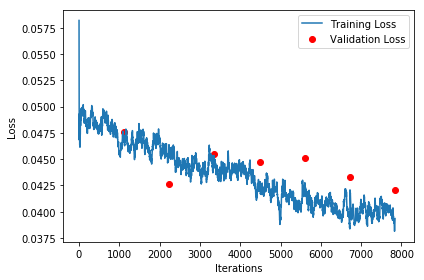

In [186]:
plot_loss(m3)

In [187]:
m3.save('embd3')

## Try even more dropout

In [192]:
m4 = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), emb_drop=0.1, out_sz=1, szs=[1000,500], drops=[0.002, 0.02], y_range=y_range)

In [194]:
m4.load('embd3')

In [195]:
m4.lr_find()

 55%|█████▍    | 611/1120 [00:20<00:16, 30.40it/s, loss=0.181]

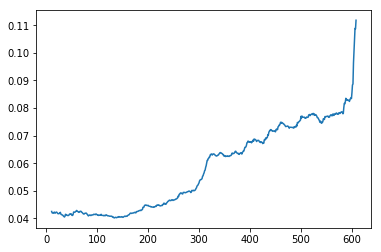

In [196]:
m4.sched.plot_loss()

1.090184492385127e-05

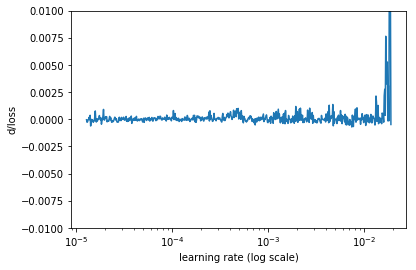

In [197]:
plot_loss_change(m4.sched)

In [198]:
lr = 1e-5

In [199]:
m4.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.040008   0.04254    0.187782  
    1      0.037508   0.043118   0.188207  
    2      0.037577   0.040036   0.18366   
    3      0.037585   0.037976   0.180066  
    4      0.034854   0.037225   0.177803  
    5      0.035121   0.038358   0.179443  
    6      0.034016   0.038776   0.179981  


[array([0.03878]), 0.1799809911693894]

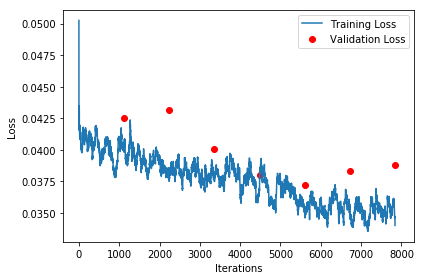

In [200]:
plot_loss(m4)

In [201]:
m4.save('embd4') 

## More training with higher learning rate

In [245]:
m5 = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), emb_drop=0.1, out_sz=1, szs=[1000,500], drops=[0.001, 0.02], y_range=y_range)

In [246]:
m5.load('embd1')

In [247]:
m5.lr_find()

 63%|██████▎   | 706/1120 [00:23<00:13, 30.34it/s, loss=0.25]

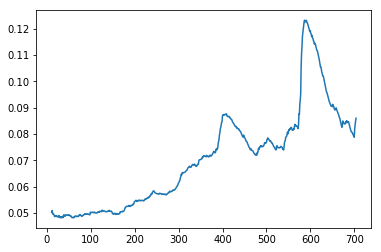

In [248]:
m5.sched.plot_loss()

0.02229534955195097

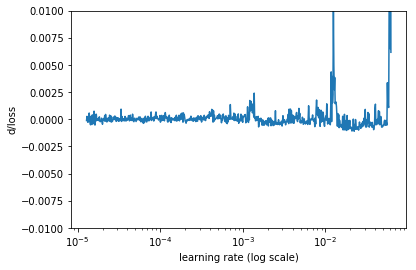

 63%|██████▎   | 706/1120 [00:40<00:23, 17.65it/s, loss=0.25]

In [249]:
plot_loss_change(m5.sched)

In [252]:
lr = 0.01

In [253]:
m5.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.016195   0.015876   0.120596  
    1      0.018102   0.014794   0.118012  
    2      0.012835   0.013944   0.112932  
    3      0.018593   0.019522   0.1282    
    4      0.015324   0.016276   0.129354  
    5      0.013499   0.01624    0.118638  
    6      0.012186   0.013966   0.112539  


[array([0.01397]), 0.11253921039812563]

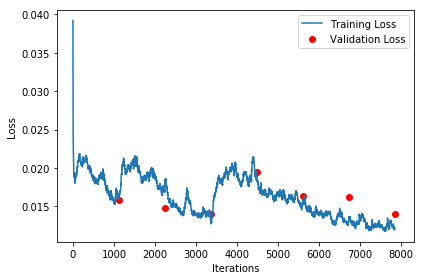

In [254]:
plot_loss(m5)

In [255]:
m5.save('embd5')

In [256]:
m5.lr_find()

 58%|█████▊    | 655/1120 [00:40<00:28, 16.37it/s, loss=0.0481]

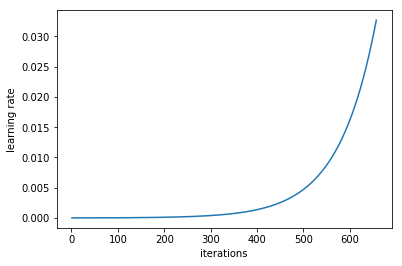

In [257]:
m5.sched.plot_lr()

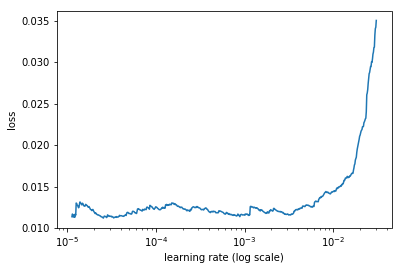

In [258]:
m5.sched.plot()

1.0249773907762154e-05

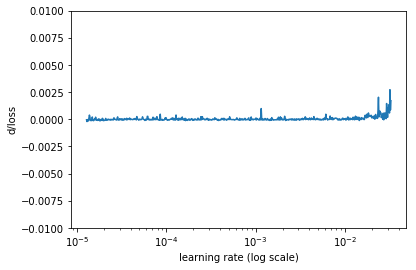

In [262]:
plot_loss_change(m5.sched)

In [265]:
lr = 1e-2

In [266]:
m5.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.013393   0.013716   0.111649  
    1      0.023545   0.020861   0.129751  
    2      0.012209   0.013944   0.112812  
    3      0.016236   0.01507    0.126881  
    4      0.015231   0.015055   0.125553  
    5      0.012377   0.013782   0.112228  
    6      0.011626   0.013176   0.111355  


[array([0.01318]), 0.11135468387289302]

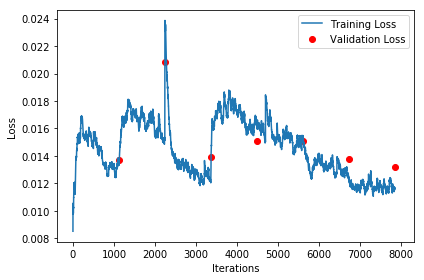

In [267]:
plot_loss(m5)

**Note: No improvement. But it is atleast neither overfitting nor underfitting**

In [268]:
m5.save('embd6')

# Model testing

## EMBD1

In [202]:
m.load('embd1')

In [203]:
y_pred,y_true=m.predict_with_targs()
exp_rmspe(y_pred,y_true)

0.1973564958420513

In [204]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [206]:
joined_test['Sales']=pred_test
csv_fn=f'{PATH}tmp/sub1.csv'
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [207]:
FileLink(csv_fn)

/home/ainsteinx/DeepLabs/data/rossman/tmp/sub1.csv

## EMBD2

In [208]:
m.load('embd2')

In [209]:
y_pred,y_true=m.predict_with_targs()
exp_rmspe(y_pred,y_true)

0.18772735322225895

In [210]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [211]:
joined_test['Sales']=pred_test
csv_fn=f'{PATH}tmp/sub2.csv'
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [212]:
FileLink(csv_fn)

/home/ainsteinx/DeepLabs/data/rossman/tmp/sub2.csv

## EMBD3

In [213]:
m.load('embd3')

In [214]:
y_pred,y_true=m.predict_with_targs()
exp_rmspe(y_pred,y_true)

0.18778321612302154

In [215]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [216]:
joined_test['Sales']=pred_test
csv_fn=f'{PATH}tmp/sub3.csv'
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [217]:
FileLink(csv_fn)

/home/ainsteinx/DeepLabs/data/rossman/tmp/sub3.csv

## EMBD4

In [218]:
m.load('embd4')

In [219]:
y_pred,y_true=m.predict_with_targs()
exp_rmspe(y_pred,y_true)

0.18041628781015323

In [220]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [221]:
joined_test['Sales']=pred_test
csv_fn=f'{PATH}tmp/sub4.csv'
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [222]:
FileLink(csv_fn)

/home/ainsteinx/DeepLabs/data/rossman/tmp/sub4.csv

## EMBD5

In [272]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), emb_drop=0.1, out_sz=1, szs=[1000,500], drops=[0.001, 0.02], y_range=y_range)

In [273]:
m.load('embd5')

In [274]:
y_pred,y_true=m.predict_with_targs()
exp_rmspe(y_pred,y_true)

0.11469765310274804

In [275]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [276]:
joined_test['Sales']=pred_test
csv_fn=f'{PATH}tmp/sub5.csv'
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [277]:
FileLink(csv_fn)

/home/ainsteinx/DeepLabs/data/rossman/tmp/sub5.csv

## EMBD6

In [278]:
m.load('embd6')

In [279]:
y_pred,y_true=m.predict_with_targs()
exp_rmspe(y_pred,y_true)

0.11354070170529103

In [280]:
pred_test=m.predict(True)
pred_test = np.exp(pred_test)

In [281]:
joined_test['Sales']=pred_test
csv_fn=f'{PATH}tmp/sub6.csv'
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [282]:
FileLink(csv_fn)

/home/ainsteinx/DeepLabs/data/rossman/tmp/sub6.csv

## RF

In [223]:
from sklearn.ensemble import RandomForestRegressor

In [224]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [225]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [226]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.9716714010516723,
 0.9104568248759715,
 0.8708280595658193,
 0.12344174556174985)